In [1]:
#importing libraries
import numpy as np 
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#setting working directory
os.chdir("F:/analytics_basics")

In [3]:
# Load CSV
train_df = pd.read_csv("train_cab.csv")

In [4]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
train_df.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [6]:
train_df['fare_amount'] = pd.to_numeric(train_df['fare_amount'], errors='coerce')
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], errors='coerce')

In [7]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


# Data exploration and cleaning

In [8]:
#checking null values in the data
print(train_df.isnull().sum())

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64


In [9]:
#drop na
train_df = train_df.dropna(how = 'any', axis = 'rows')

#replace 0's in coordinates with null values
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

#now removing these rows with null values
for i in coord :
    train_df[i] = train_df[i].replace(0,np.nan)
    train_df    = train_df[train_df[i].notnull()]


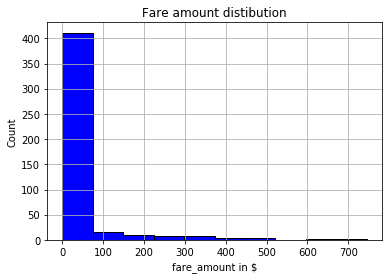

In [10]:
#plotting to see the distribution of fare_amount
train_df['fare_amount'].value_counts().hist(color = 'b', edgecolor = 'k');
plt.title('Fare amount distibution'); plt.xlabel('fare_amount in $'); plt.ylabel('Count');

In [11]:
#checking for outliers
#but we wont use this method as it leaves out important data
q75, q25 = np.percentile(train_df.loc[:,i], [75 ,25])
iqr = q75 - q25
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)
print(min)
print(max)

40.688194624999994
40.81637362500001


In [12]:
#removing the values less than 0 and greater than 99.99 percentile
train_df = train_df[ (train_df["fare_amount"] > 0 ) &
                     (train_df["fare_amount"]  <  
                      train_df["fare_amount"].quantile(.9999))]

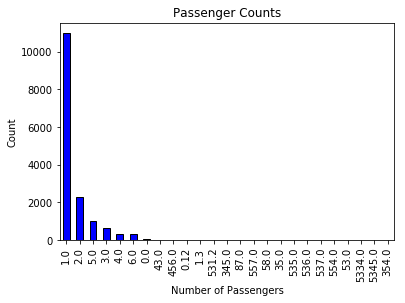

In [13]:
#plotting to see the distribution of passenger_count
train_df['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

In [14]:
#only accepting rows with values greter thn or equal to 1 or less than 7.
train_df = train_df[(train_df["passenger_count"] >=1 ) &
                        (train_df["passenger_count"] < 7) ]

In [15]:
#removing the values less than 0 and greater than 99.99 percentile
coords = ['pickup_longitude','pickup_latitude', 
          'dropoff_longitude', 'dropoff_latitude']
for i in coord  : 
    train_df = train_df[(train_df[i]   > train_df[i].quantile(.001)) & 
                        (train_df[i] < train_df[i].quantile(.999))]

In [16]:
#adding new variables to data
def add_travel_vector_features(df):
    df['diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

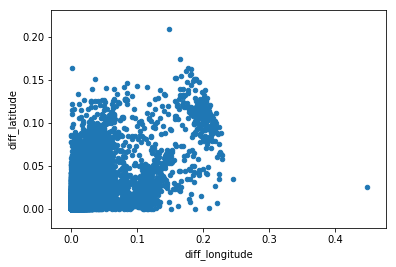

In [17]:
plot = train_df.plot.scatter('diff_longitude', 'diff_latitude')

In [18]:
#getting distance between pickup and dropoff location using haversine function
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2) :
  R = 6371 #radius of earth
  dLat = deg2rad(lat2-lat1)
  dLon = deg2rad(lon2-lon1)
  a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dLon/2) * np.sin(dLon/2)
    
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  d = R * c
  return d

def deg2rad(deg) :
    PI=22/7

    return deg * (PI/180)


In [19]:
train_df['distance']= getDistanceFromLatLonInKm(train_df['pickup_longitude'],train_df['pickup_latitude'],train_df['dropoff_longitude'],train_df['dropoff_latitude'])

In [20]:
#checking rows with distance equal to zero
train_df[ (train_df["distance"] == 0 )]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,diff_longitude,diff_latitude,distance
105,52.00,2009-03-25 00:08:52,-74.035839,40.747320,-74.035839,40.747320,1.0,0.0,0.0,0.0
191,6.50,2014-01-08 21:55:58,-73.998488,40.726303,-73.998488,40.726303,1.0,0.0,0.0,0.0
270,7.50,2012-08-25 01:53:42,-73.995892,40.746454,-73.995892,40.746454,1.0,0.0,0.0,0.0
290,6.90,2009-12-14 12:33:00,-73.982432,40.745747,-73.982432,40.745747,1.0,0.0,0.0,0.0
396,12.00,2014-03-12 18:12:44,-73.844904,40.736318,-73.844904,40.736318,1.0,0.0,0.0,0.0
657,2.50,2009-08-25 01:50:21,-73.986410,40.763350,-73.986410,40.763350,1.0,0.0,0.0,0.0
737,57.33,2014-08-11 19:37:00,-73.776477,40.646290,-73.776477,40.646290,2.0,0.0,0.0,0.0
808,6.10,2010-10-22 02:24:53,-73.984433,40.771084,-73.984433,40.771084,1.0,0.0,0.0,0.0
843,5.50,2014-07-19 04:42:00,-73.990532,40.719085,-73.990532,40.719085,1.0,0.0,0.0,0.0
1124,10.10,2010-10-14 21:12:17,-73.976390,40.770868,-73.976390,40.770868,1.0,0.0,0.0,0.0


In [21]:
#removing rows with distance equal to zero
train_df = train_df[ (train_df["distance"] > 0 )]

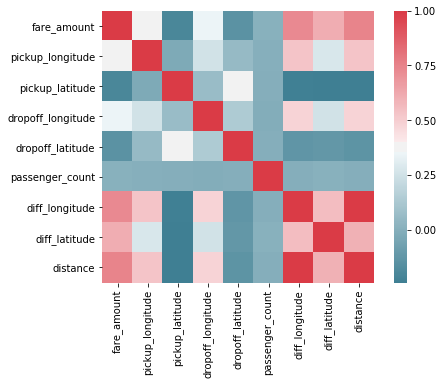

In [22]:
#checking co-relation between different variables for feature selevtion
cnames =  ["fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude", "passenger_count","diff_longitude","diff_latitude", "distance"]
##Correlation analysis
#Correlation plot
df_corr = train_df.loc[:,cnames]

#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Machine Learning

In [23]:
#######################################   Linear Regression #############################################################
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [24]:
# Bin the fare and convert to string
train_df['fare_bin'] = pd.cut(train_df['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
# Uppermost bin
train_df.loc[train_df['fare_bin'] == 'nan', 'fare_bin'] = '[45+]'

In [25]:
#Dividing the data in 80:20 ratio wih fare_bin as strafication variable.
Rest, Sample = train_test_split(train_df, test_size = 0.8, stratify = train_df['fare_bin'])

In [26]:
#training the model with "Sample" data
model = sm.OLS(Sample.iloc[:,0], Sample.iloc[:,6:9].astype(float)).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 1.915e+04
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:38:46   Log-Likelihood:                -39811.
No. Observations:               12250   AIC:                         7.963e+04
Df Residuals:                   12247   BIC:                         7.965e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
passenger_count     1.2535      0.033     38.453      0.000       1.190       1.317
diff_longitude    183.6676      2.036     90.194      0.000     179.676     187.659
diff_latitude     176.0499      2.874     61.246      0.000     170.416     181.684
==============================================================================
Omnibus:                    33022.200   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2694344277.202
Skew:                          32.413   Prob(JB):                         0.00
Kurtosis:                    2299.631   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
#making predictions of fare_amount using the variables in "Rest".
predictions_LR = model.predict(Rest.iloc[:,6:9])

In [29]:
#calculating different error metrics to check the accuracy of model
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape
#Calculate MAPE
MAPE(Rest.iloc[:,0], predictions_LR)


28.03407360022401

In [30]:
#Calculate RMSE
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse
#Calculate RMSE
RMSE(Rest.iloc[:,0], predictions_LR)

9.061168320969625

In [31]:
#######################################   Decision Tree #############################################################
#traing the decision tree regression model
fit_DT = DecisionTreeRegressor(max_depth=5).fit(Sample.iloc[:,6:9], Sample.iloc[:,0])

In [32]:
fit_DT

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
#making predictions of fare_amount using the variables in "Rest".
predictions_DT = fit_DT.predict(Rest.iloc[:,6:9])

In [34]:
#Calculate MAPE
MAPE(Rest.iloc[:,0], predictions_DT)

24.743479497510894

In [35]:
#Calculate RMSE
RMSE(Rest.iloc[:,0], predictions_DT)

8.69183725860175

In [36]:
#######################################   Random Forest #############################################################
RF_model = RandomForestRegressor(n_estimators = 200).fit(Sample.iloc[:,6:9], Sample.iloc[:,0])

In [37]:
#making predictions of fare_amount using the variables in "Rest".
predictions_RF = RF_model.predict(Rest.iloc[:,6:9])

In [38]:
#Calculate MAPE
MAPE(Rest.iloc[:,0], predictions_RF)

23.771431358444374

In [39]:
#Calculate RMSE
RMSE(Rest.iloc[:,0], predictions_RF)

8.787009145869012

In [40]:
#######################################   KNN Regression #############################################################
KNN_model = KNeighborsRegressor(n_neighbors = 110).fit(Sample.iloc[:,6:9], Sample.iloc[:,0])

In [41]:
#making predictions of fare_amount using the variables in "Rest".
predictions_KNN = KNN_model.predict(Rest.iloc[:,6:9])

In [42]:
#Calculate MAPE
MAPE(Rest.iloc[:,0], predictions_KNN)

21.54094919893087

In [43]:
#making predictions of fare_amount on whole training data set
predictions_KNN2 = KNN_model.predict(train_df.iloc[:,6:9])

In [44]:
#Calculate MAPE of train_df
MAPE(train_df.iloc[:,0], predictions_KNN2)

25.583996156876687

In [45]:
#Calculate RMSE
RMSE(Rest.iloc[:,0], predictions_KNN)

8.862743544956764

In [46]:
#########################################################################################################################

In [47]:
#Since KNN has minimum MAPE value, it is accepted as the model to predict values of test.csv
# Load CSV
test = pd.read_csv("test.csv")

In [48]:
#checking null values in the data
print(test.isnull().sum())

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [49]:
#adding diff_lat/long to test
add_travel_vector_features(test)

In [50]:
test.iloc[:,5:8]

,passenger_count,diff_longitude,diff_latitude
0,1,0.008110,0.019970
1,1,0.012024,0.019817
2,1,0.002870,0.005121
3,1,0.009288,0.016172
4,1,0.022519,0.045348
5,1,0.018194,0.025494
6,1,0.010609,0.002311
7,1,0.207801,0.112732
8,1,0.018993,0.031727
9,1,0.011104,0.005206


In [51]:
test['fare_amount'] = KNN_model.predict(test.iloc[:,5:8])

In [52]:
test

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,diff_longitude,diff_latitude,fare_amount
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,8.360000
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,8.618182
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,4.620000
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,7.572727
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,14.150000
5,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1,0.018194,0.025494,9.519091
6,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1,0.010609,0.002311,5.733636
7,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1,0.207801,0.112732,50.994182
8,2011-10-06 12:10:20 UTC,-74.014099,40.709638,-73.995106,40.741365,1,0.018993,0.031727,10.657000
9,2014-02-18 15:22:20 UTC,-73.969582,40.765519,-73.980686,40.770725,1,0.011104,0.005206,5.990909


In [53]:
# Writing a csv (output)
test.to_csv("test_new_py.csv", index = False)